# Figure 10
Plots for future devil population with vaccination intervention

In [1]:
import os
import sys
sys.path.insert(1, os.path.abspath(os.path.join(os.getcwd(), '../GillesPy2')))

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,mark_inset)

In [3]:
from gillespy2 import TauHybridCSolver

In [4]:
from dask.distributed import Client
from dask import delayed

In [5]:
sys.path.insert(2, os.path.abspath(os.path.join(os.getcwd(), './ParameterSweeps')))
from Devils_DFTD_2_Stage_Infection import DevilsDFTD2StageInfection
from Simulation import Simulation, devil_pop
from ParameterSweep import ParameterSweep

In [6]:
c = Client(n_workers=8, threads_per_worker=1)
# c = Client("james.cs.unca.edu:12345")

In [7]:
dates = []
year = 1985
while len(dates) < 1001:
    for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]:
        dates.append(f"{month} {year}")
    year += 1

## Load Simulation

In [8]:
def get_params(key):
    params = [param.split(":") for param in key.split(",")]
    return {param[0]: float(param[1]) for param in params}

In [9]:
def load_simulation(data_path, key):
    if os.path.exists(data_path):
        with open(data_path, "rb") as data_file:
            sim = pickle.load(data_file)
        return Simulation.load_state(sim)
    
    data_path = "./ParameterSweeps/DevilsDFTD2StageInfectionWithVaccinationState.p"
    if os.path.exists(data_path):
        with open(data_path, "rb") as state_file:
            sim = pickle.load(state_file)['job'].results[key]
        return Simulation.load_state(sim)
    
    model = DevilsDFTD2StageInfection(devil_pop, interventions="vaccination")
    
    sol = delayed(TauHybridCSolver)(model=model, variable=True)
    
    params = get_params(key)
    
    sim = Simulation(model, variables=params)
    sim.configure(solver=sol)
    return sim

In [10]:
def plot_figure(sim, start=0, alpha=0.3, plot_observed=False, plot_immunity_level=True, save_fig=None):
    carry_cap = int(max(devil_pop)*1.16)
    dftd_start = int(sim.result[0].model.listOfParameters['DFTD_introduction'].value)

    x = sim.result[0]['time'][start:]
    text_offset = (sim.result[0]['time'].size - start) / 601

    fig, ax1 = plt.subplots(figsize=[15, 8])
    title = f"Tasmanian Devil Population with DFTD and Vaccination Intervention"
    plt.title(title, fontsize=18)
    ax1.set_ylabel("Population of Tasmanian Devils", fontsize=14)

    for i, result in enumerate(sim.result):
        spec_list = [sim.result[i]['Juvenile'], sim.result[i]['Susceptible'], sim.result[i]['Exposed'],
                 sim.result[i]['Infected'], sim.result[i]['Diseased'], sim.result[i]['Vaccinated']]
        total_devils = np.add.reduce(spec_list)
        if i == 0:
            ax1.plot(x, total_devils[start:], color='blue', label='Total Devils')
            ax1.plot(x, sim.result[i]['Juvenile'][start:], color='purple', label='Juvenile', alpha=alpha)
            ax1.plot(x, sim.result[i]['Susceptible'][start:], color='green', label='Susceptible', alpha=alpha)
            ax1.plot(x, sim.result[i]['Exposed'][start:], color='magenta', label='Exposed', alpha=alpha)
            ax1.plot(x, sim.result[i]['Infected'][start:], color='red', label='Infected', alpha=alpha)
            ax1.plot(x, sim.result[i]['Diseased'][start:], color='brown', label='Diseased', alpha=alpha)
            ax1.plot(x, sim.result[i]['Vaccinated'][start:], color='cyan', label='Vaccinated', alpha=alpha)
        else:
            ax1.plot(x, total_devils[start:], color='blue', alpha=alpha)
            ax1.plot(x, sim.result[i]['Juvenile'][start:], color='purple', alpha=alpha)
            ax1.plot(x, sim.result[i]['Susceptible'][start:], color='green', alpha=alpha)
            ax1.plot(x, sim.result[i]['Exposed'][start:], color='magenta', alpha=alpha)
            ax1.plot(x, sim.result[i]['Infected'][start:], color='red', alpha=alpha)
            ax1.plot(x, sim.result[i]['Diseased'][start:], color='brown', alpha=alpha)
            ax1.plot(x, sim.result[i]['Vaccinated'][start:], color='cyan', alpha=alpha)


    if plot_observed:
        ax1.plot(range(len(devil_pop)), devil_pop, '--k', label='Observed')

    # DFTD Introduction
    if start <= dftd_start:
        ax1.plot([dftd_start, dftd_start], [-3000, carry_cap], '--k', alpha=0.3)
        ax1.text(dftd_start - 10 * text_offset, 32000, "DFTD Introduced",
                 rotation="vertical", color="black", fontsize=12)
        ax1.text(dftd_start + 3 * text_offset, 35000, dates[dftd_start],
                 rotation="vertical", color="black", fontsize=12)

    ax2 = plt.axes([0,0,1,1])
    # Manually set the position and relative size of the inset axes within ax1
    ip = InsetPosition(ax1, [0.27,0.67,0.15,0.25])
    ax2.set_axes_locator(ip)
    # Mark the region corresponding to the inset axes on ax1 and draw lines
    # in grey linking the two axes.
    mark_inset(ax1, ax2, loc1=4, loc2=3, fc="none", ec='0.5')

    # plot in the inset
    inst=440
    ined=inst+21
    for i, result in enumerate(sim.result):
        spec_list = [sim.result[i]['Juvenile'], sim.result[i]['Susceptible'], sim.result[i]['Exposed'],
                 sim.result[i]['Infected'], sim.result[i]['Diseased'], sim.result[i]['Vaccinated']]
        total_devils = np.add.reduce(spec_list)
        if i == 0:
            ax2.plot(x, total_devils[start:], color='blue', label='Total Devils')
            ax2.plot(x, sim.result[i]['Juvenile'][start:], color='purple', alpha=0.6, label='Juvenile')
            ax2.plot(x, sim.result[i]['Susceptible'][start:], color='green', alpha=0.6, label='Susceptible')
            ax2.plot(x, sim.result[i]['Exposed'][start:], color='magenta', alpha=0.6, label='Exposed')
            ax2.plot(x, sim.result[i]['Infected'][start:], color='red', alpha=0.6, label='Infected')
            ax2.plot(x, sim.result[i]['Diseased'][start:], color='brown', alpha=0.6, label='Diseased')
            ax2.plot(x, sim.result[i]['Vaccinated'][start:], color='cyan', alpha=0.6, label='Vaccinated')
        else:
            ax2.plot(x, total_devils[start:], color='blue', alpha=alpha)
            ax2.plot(x, sim.result[i]['Juvenile'][start:], color='purple', alpha=alpha*2.5)
            ax2.plot(x, sim.result[i]['Susceptible'][start:], color='green', alpha=alpha*2.5)
            ax2.plot(x, sim.result[i]['Exposed'][start:], color='magenta', alpha=alpha*2.5)
            ax2.plot(x, sim.result[i]['Infected'][start:], color='red', alpha=alpha*2.5)
            ax2.plot(x, sim.result[i]['Diseased'][start:], color='brown', alpha=alpha*2.5)
            ax2.plot(x, sim.result[i]['Vaccinated'][start:], color='cyan', alpha=alpha*2.5)
    ax2.set_xlim(inst,ined-1)
    ax2.set_xticks([inst+5, inst+15, ined-6])
    ax2.set_xticklabels([dates[inst+5], dates[inst+15], dates[ined-6]])
    ax2.set_ylim(0,10000)
    ax2.set_yticks([0,3000,6000,9000 ])
    ax2.tick_params(axis='y', labelrotation=90)
    
    # Vaccination
    if sim.variables is not None and "vaccine_start" in sim.variables.keys():
        vaccine_start = sim.variables['vaccine_start']
    else:
        vaccine_start = int(sim.result[0].model.listOfParameters['vaccine_start'].value)

    if sim.variables is None or 'vacc_program_length' not in sim.variables:
        vacc_program_length = sim.result[0].model.listOfParameters['vacc_program_length'].value
        vaccine_end = vaccine_start + 12 * int(vacc_program_length)
    else:
        vaccine_end = vaccine_start + 12 * int(sim.variables['vacc_program_length'])

    ax1.plot([vaccine_start, vaccine_start], [-3000, carry_cap - 3000], '--k', alpha=0.3)
    ax1.plot([vaccine_end, vaccine_end], [-3000, carry_cap - 3000], '--k', alpha=0.3)
    ax1.plot([vaccine_start, vaccine_end], [carry_cap - 3000, carry_cap - 3000], '--k', alpha=0.3)
    ax1.text(
        vaccine_start, carry_cap - 2300, f"Vaccine: {dates[vaccine_start]} - {dates[vaccine_end]}",
        color="black", fontsize=12
    )

    ax1.set_ylim(-3000, carry_cap)
    ax1.set_xlim(-5, 1005)
    x_ticks, x_ticklabels = sim._get_x_ticklabels()
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_ticklabels)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.tick_params(axis='y',labelsize=12, labelrotation=90)
    ax1.legend(loc='upper right', fontsize=12)
    fig.tight_layout()

    if save_fig is not None:
        plt.savefig(save_fig)

## Run Simulation for figure 10a

In [11]:
fig_10a_path = "figure_data/Fig10a-data.p"
fig_10a_key = "vaccinated_infection_rate:0.6,vaccination_proportion:0.8,vacc_program_length:10,vaccine_frequency:2"

In [12]:
fig_10a_sim = load_simulation(fig_10a_path, fig_10a_key)

In [13]:
%time _ = fig_10a_sim.run(use_existing_results=True)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 7.15 µs


In [14]:
if not os.path.exists(fig_10a_path):
    with open(fig_10a_path, "wb") as fig_10a_data_file:
        pickle.dump(fig_10a_sim, fig_10a_data_file)

## Plots for figure 10a

/var/folders/z4/bqpnd_kx7xg3s3c9jtz0pnfh0000gn/T/ipykernel_4797/3143597986.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


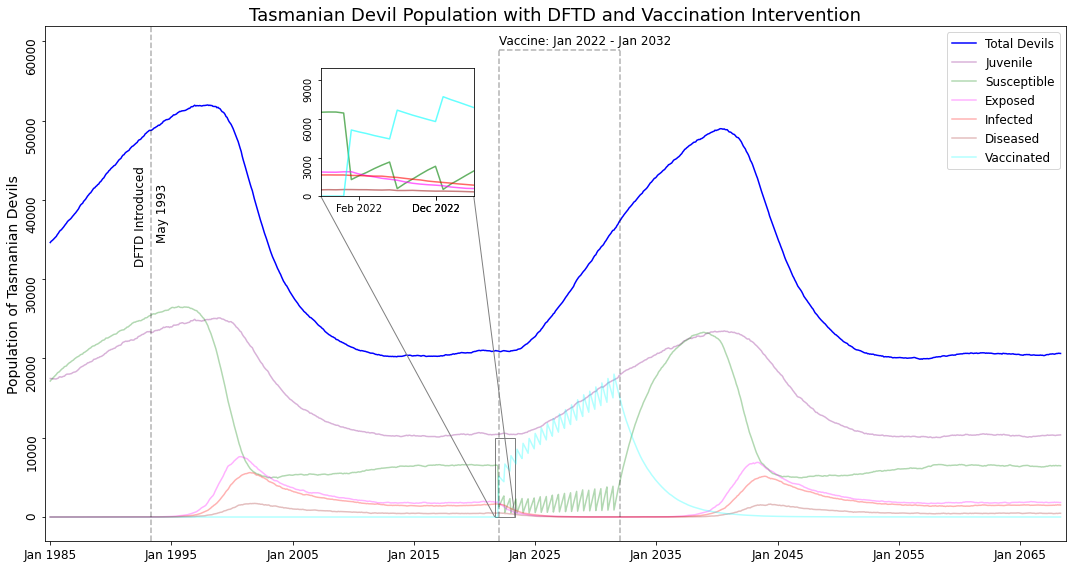

In [15]:
plot_figure(fig_10a_sim)

In [16]:
# plot_figure(fig_10a_sim, save_fig="DFTDmodel_sec4_vaccination.pdf")

## Run Simulation for figure 10b

In [17]:
fig_10b_path = "figure_data/Fig10b-data.p"
fig_10b_key = "vaccinated_infection_rate:0.6,vaccination_proportion:0.8,vacc_program_length:10,vaccine_frequency:6"

In [18]:
fig_10b_sim = load_simulation(fig_10b_path, fig_10b_key)

In [19]:
%time _ = fig_10b_sim.run(use_existing_results=True, success=True)

CPU times: user 63 µs, sys: 6 µs, total: 69 µs
Wall time: 64.8 µs


In [20]:
if not os.path.exists(fig_10b_path):
    with open(fig_10b_path, "wb") as fig_10b_data_file:
        pickle.dump(fig_10b_sim, fig_10b_data_file)

## Plots for figure 10b

/var/folders/z4/bqpnd_kx7xg3s3c9jtz0pnfh0000gn/T/ipykernel_4797/3143597986.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


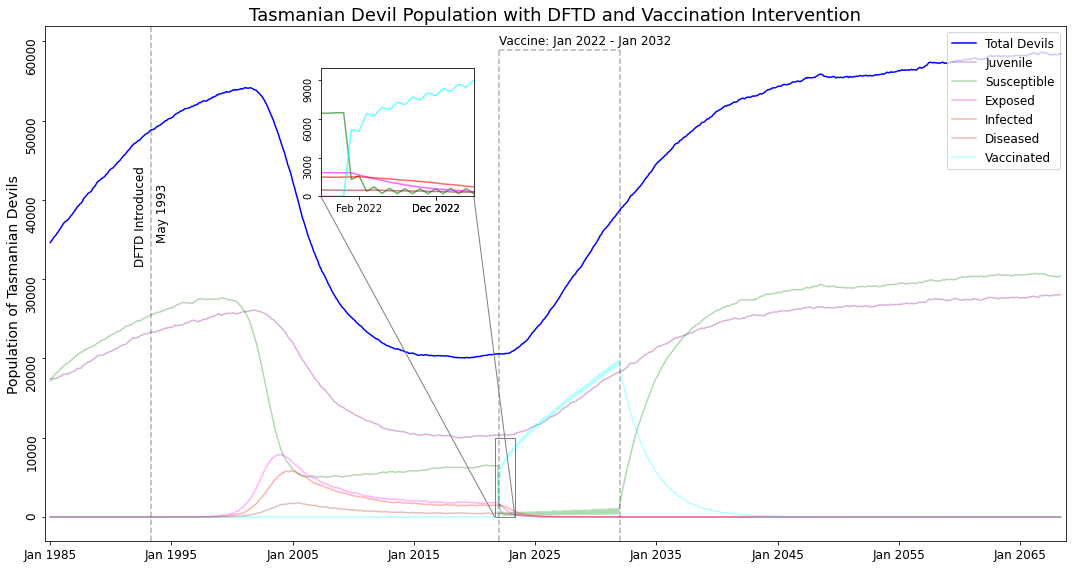

In [21]:
plot_figure(fig_10b_sim)

In [22]:
# plot_figure(fig_10b_sim, save_fig="DFTDmodel_sec4_vaccination-successful.pdf")

## Run Simulation for figure 10c

In [23]:
fig_10c_path = "figure_data/Fig10c-data.p"
fig_10c_key = "vaccinated_infection_rate:0.4,vaccination_proportion:0.8,vacc_program_length:9,vaccine_frequency:4"

In [24]:
fig_10c_sim = load_simulation(fig_10c_path, fig_10c_key)

In [25]:
%time _ = fig_10c_sim.run(use_existing_results=True, store_all_results=True)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 8.82 µs


In [26]:
if not os.path.exists(fig_10c_path):
    with open(fig_10c_path, "wb") as fig_10c_data_file:
        pickle.dump(fig_10c_sim, fig_10c_data_file)

## Plots for figure 10c

In [27]:
def plot_figure_10c(sim, start=0, alpha=0.3, plot_observed=False, plot_immunity_level=True, save_fig=None):
    carry_cap = int(max(devil_pop)*1.16)
    dftd_start = int(sim.result[0].model.listOfParameters['DFTD_introduction'].value)

    x = sim.result[0]['time'][start:]
    text_offset = (sim.result[0]['time'].size - start) / 601

    fig, ax1 = plt.subplots(figsize=[15, 8])
    title = f"Tasmanian Devil Population with DFTD and Vaccination Intervention"
    plt.title(title, fontsize=18)
    ax1.set_ylabel("Population of Tasmanian Devils", fontsize=14)

    for i, result in enumerate(sim.result):
        spec_list = [sim.result[i]['Juvenile'], sim.result[i]['Susceptible'], sim.result[i]['Exposed'],
                 sim.result[i]['Infected'], sim.result[i]['Diseased'], sim.result[i]['Vaccinated']]
        total_devils = np.add.reduce(spec_list)
        if i == 0:
            ax1.plot(x, total_devils[start:], color='blue', alpha=alpha, label='Total Devils')
        else:
            ax1.plot(x, total_devils[start:], color='blue', alpha=alpha)

    if plot_observed:
        ax1.plot(range(len(devil_pop)), devil_pop, '--k', label='Observed')

    # DFTD Introduction
    if start <= dftd_start:
        ax1.plot([dftd_start, dftd_start], [-3000, carry_cap], '--k', alpha=0.3)
        ax1.text(dftd_start - 10 * text_offset, 45000, "DFTD Introduced",
                 rotation="vertical", color="black", fontsize=12)
        ax1.text(dftd_start + 3 * text_offset, 48000, dates[dftd_start],
                 rotation="vertical", color="black", fontsize=12)

    # Vaccination
    if sim.variables is not None and "vaccine_start" in sim.variables.keys():
        vaccine_start = sim.variables['vaccine_start']
    else:
        vaccine_start = int(sim.result[0].model.listOfParameters['vaccine_start'].value)

    if sim.variables is None or 'vacc_program_length' not in sim.variables:
        vacc_program_length = sim.result[0].model.listOfParameters['vacc_program_length'].value
        vaccine_end = vaccine_start + 12 * int(vacc_program_length)
    else:
        vaccine_end = vaccine_start + 12 * int(sim.variables['vacc_program_length'])

    ax1.plot([vaccine_start, vaccine_start], [-3000, carry_cap - 3000], '--k', alpha=0.3)
    ax1.plot([vaccine_end, vaccine_end], [-3000, carry_cap - 3000], '--k', alpha=0.3)
    ax1.plot([vaccine_start, vaccine_end], [carry_cap - 3000, carry_cap - 3000], '--k', alpha=0.3)
    ax1.text(
        vaccine_start, carry_cap - 2300, f"Vaccine: {dates[vaccine_start]} - {dates[vaccine_end]}",
        color="black", fontsize=12
    )

    ax1.set_ylim(-3000, carry_cap)
    ax1.set_xlim(-5, 1005)
    x_ticks, x_ticklabels = sim._get_x_ticklabels()
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_ticklabels)
    ax1.tick_params(axis='x', labelsize=12)
    ax1.tick_params(axis='y',labelsize=12, labelrotation=90)
    ax1.legend(loc='upper right', fontsize=12)
    fig.tight_layout()

    if save_fig is not None:
        plt.savefig(save_fig)

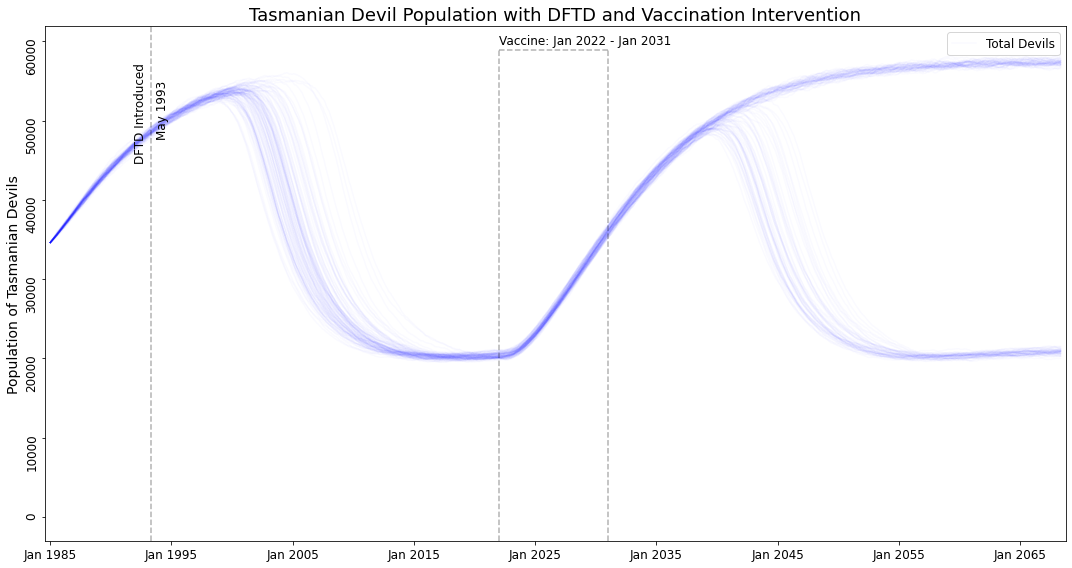

In [28]:
plot_figure_10c(fig_10c_sim, alpha=0.02)

In [29]:
# plot_figure_10c(fig_10c_sim, alpha=0.02, save_fig="DFTDmodel_sec4_vaccination-variable-success.pdf")